Notebook for generating occupancy graph.

Alternatively, this repo includes `code/occupancy.py`, a small utility to parse tracking `.txt` files (single or multi-fish) and produce an occupancy heatmap (summed over time and fish).

Quick command-line examples (run from the repo root):

- Run the occupancy script directly on a single file or a folder containing `.txt` files:

# process one file and save an image (matplotlib infers extension from --out)
python code\occupancy.py "source_paper\Zebrafish_Positions_data\Heterogeneous_1AB\1AB_heterogeneous_01.txt" --out "examples/example_occupancy.png" --bins 200 200 --tank 200 200

# or process a folder of files (the script will aggregate results)
python code\occupancy.py "source_paper\Zebrafish_Positions_data\Heterogeneous_10AB\" --out "examples/example_occupancy.png" --bins 200 200 --tank 200 200

Example output
- A sample occupancy image created by the example script is included at `examples/example_occupancy.png`.

In [6]:
from typing import Optional, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [ ]:
data_path = Path('..') / 'source_paper' / 'Zebrafish_Positions_data' / 'Heterogeneous_10AB'

In [31]:
def read_tracking_file(path: str, duration: Optional[float] = None) -> pd.DataFrame:
    """Read a tracking text file into a long-form pandas DataFrame.

    The returned DataFrame will have columns: ['time','fish_id','x','y'].

    Parameters
    - path: path to the .txt file, expects whitespace-separated values and comments starting with #
    - duration: total duration in seconds (used when timestamps are not present,
      to normalize frames to seconds). Default None, needs timestamps.

    The reader attempts to detect data layout:
    - 2 columns: assumed to be x y (single fish). time will be generated.
    - 3 columns: assumed to be time x y (single fish).
    - N>3 columns: if N is even -> pairs x1 y1 x2 y2 ... (no time)
      if N is odd -> first column is time/frame, rest are pairs x y.

    Returns
    - DataFrame with columns ['time','fish_id','x','y'] with one row per sample
      per fish.
    """
    
    path = os.fspath(path)
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    # Read raw table. Whitespace separated, comments starting with #
    raw = pd.read_csv(path, sep=r'\s+', header=None, comment='#', engine='python')
    ncols = raw.shape[1]

    if duration is None and ncols % 2 == 0:
        raise ValueError("Duration must be provided when timestamps are not present in the data.")

    # Helper to build long df from arrays
    def build_long(time_arr, xs, ys):
        # xs, ys are 2D arrays: (n_rows, n_fish)
        n_rows, n_fish = xs.shape
        # repeat time per fish
        times = np.repeat(time_arr.reshape(-1, 1), n_fish, axis=1).ravel()
        fish_ids = np.tile(np.arange(1, n_fish + 1), n_rows)
        xs_flat = xs.ravel()
        ys_flat = ys.ravel()
        df = pd.DataFrame({'time': times, 'fish_id': fish_ids, 'x': xs_flat, 'y': ys_flat})
        return df

    if ncols == 2:
        # assume x y for single fish
        xs = raw.iloc[:, 0].to_numpy()
        ys = raw.iloc[:, 1].to_numpy()
        time = np.linspace(0, duration, num=len(xs))
        return pd.DataFrame({'time': time, 'fish_id': 1, 'x': xs, 'y': ys})

    if ncols == 3:
        # assume time x y
        time = raw.iloc[:, 0].to_numpy()
        xs = raw.iloc[:, 1].to_numpy()
        ys = raw.iloc[:, 2].to_numpy()
        return pd.DataFrame({'time': time, 'fish_id': 1, 'x': xs, 'y': ys})

    # ncols > 3: detect pairs
    if ncols > 3:
        if ncols % 2 == 0:
            # no explicit time column, generate it
            n_fish = ncols // 2
            arr = raw.to_numpy()
            xs = arr[:, 0::2]
            ys = arr[:, 1::2]
            time = np.linspace(0, duration, num=arr.shape[0])
            return build_long(time, xs, ys)
        else:
            #first column time/frame, rest pairs x y
            time = raw.iloc[:, 0].to_numpy()
            rest = raw.iloc[:, 1:]
            arr = rest.to_numpy()
            xs = arr[:, 0::2]
            ys = arr[:, 1::2]
            return build_long(time, xs, ys)

In [ ]:
def create_occupancy_map(df: pd.DataFrame,
                         bins: Tuple[int, int] = (30, 30),
                         tank_size: Optional[Tuple[float, float]] = None,
                         cmap: str = 'magma') -> Tuple[plt.Figure, plt.Axes, np.ndarray, np.ndarray, np.ndarray]:
    """Create and plot a 2D occupancy heatmap from a long-form DataFrame.

    Parameters
    - df: DataFrame produced by read_tracking_file with columns ['time','fish_id','x','y']
    - bins: (nx, ny) number of bins for histogram
    - tank_size: optional (width, height) in same units as x and y. If provided,
      the heatmap extent will be [0,width,0,height]. If not provided the extent
      is inferred from the data min/max.
    - cmap: matplotlib colormap name

    Returns (fig, ax, H, xedges, yedges)
    - H is the 2D histogram (counts), xedges and yedges are bin edges.
    """
    if not {'x', 'y'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'x' and 'y' columns")

    xs = df['x'].to_numpy()
    ys = df['y'].to_numpy()

    if tank_size is None:
        xmin, xmax = np.nanmin(xs), np.nanmax(xs)
        ymin, ymax = np.nanmin(ys), np.nanmax(ys)
    else:
        width, height = tank_size
        xmin, ymin = 0.0, 0.0
        xmax, ymax = width, height
        
    total_counts = len(xs)

    # compute 2D histogram
    H, xedges, yedges = np.histogram2d(xs, ys, bins=bins, range=[[xmin, xmax], [ymin, ymax]])

    # Normalize by total counts
    if total_counts > 0:
        H = H / total_counts

    # Plot
    fig, ax = plt.subplots(figsize=(6, 5))
    # imshow expects extent = [xmin, xmax, ymin, ymax]
    img = ax.imshow(H.T, origin='upper', extent=(xmin, xmax, ymin, ymax), cmap=cmap, aspect='auto') # set vmax=0.003 for same color scale as paper
    #ax.set_xlabel('X (units)')
    #ax.set_ylabel('Y (units)')
    ax.set_title('Occupancy map for bins={}, num_fish={}'.format(bins, df['fish_id'].nunique()))
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('Counts')

    return fig, ax, H, xedges, yedges

In [35]:
dfs = []
if os.path.isfile(data_path):
    dfs.append(read_tracking_file(data_path))
else:
    for data_file in Path(data_path).glob('*.txt'):
        dfs.append(read_tracking_file(data_file))

if dfs:
    df = pd.concat(dfs, ignore_index=True)
else:
    df = pd.DataFrame(columns=['time', 'fish_id', 'x', 'y'])

0.006378783671202444


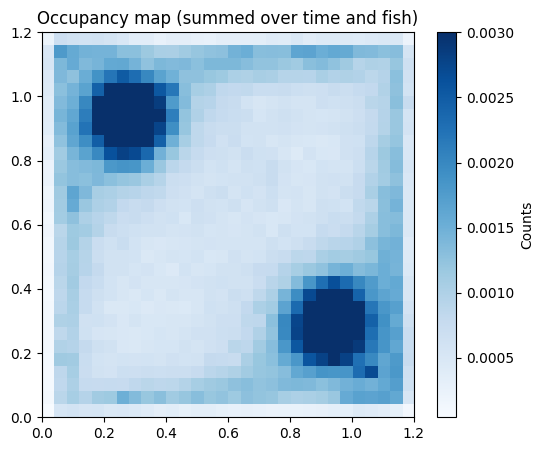

In [36]:
fig, ax, H, xedges, yedges = create_occupancy_map(df, bins=(30, 30), tank_size=(1.2, 1.2), cmap='Blues')

print(max(H.flatten()))